In [ ]:
%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
plt.rcParams.update({"font.family":"serif", "font.size":14})

#from glob import glob
from pathlib import Path
import os, time

import numpy as np

import xarray as xr
#from xorca.lib import load_xorca_dataset
#from xgcm import Grid

#from itidenatl.nemodez import Vmodes
#import itidenatl.eos as eos
#import itidenatl.vars as var
#import itidenatl.gridop as gop
import itidenatl.utils as ut

In [2]:
from dask.distributed import Client, LocalCluster, wait
cluster = LocalCluster(n_workers=8) #n_workers=24, threads_per_worker=1, memory_limit=8e6,silence_logs=50
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:33577 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 56 Memory: 236.33 GiB


In [11]:
### define paths
scratchdir = Path(os.getenv("SCRATCHDIR"))
workdir = Path("/work/CT1/ige2071/nlahaye")
#worksha = (workdir/"../SHARED").resolve()

#vmod_path = worksha/"vmodes/vmodes_10.zarr"
#ssh_path = Path("/store/albert7a/eNATL60/zarr/eNATL60-BLBT02-SSH-1h") # zarr
hbot_path = workdir/"eNATL60_mean_grid_z.zarr"
grid_path = scratchdir/"mesh_mask_eNATL60_3.6.nc"


In [4]:
ds = xr.open_zarr(hbot_path)

### add lon, lat coords
chks = {k[0]:v[0] for k,v in ds.chunks.items() if k in ["x_c", "y_c"]}
for c in ["llon_cc", "llat_cc"]:
    if c in ds.coords:
        ds[c] = ut.open_one_coord(grid_path, chunks=chks, varname=c)[c]
    else:
        ds = ds.assign_coords({c:ut.open_one_coord(grid_path, chunks=chks, varname=c)[c]})
ds

In [14]:
hbot = ds.hbot.load()
hbot

<xarray.DataArray 'hbot' (y_c: 4729, x_c: 8354)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * x_c      (x_c) int64 1 2 3 4 5 6 7 8 ... 8348 8349 8350 8351 8352 8353 8354
  * y_c      (y_c) int64 1 2 3 4 5 6 7 8 ... 4723 4724 4725 4726 4727 4728 4729
    llon_cc  (y_c, x_c) float32 -97.88 -97.87 -97.85 -97.83 ... 47.1 47.12 47.13
    llat_cc  (y_c, x_c) float32 6.337 6.337 6.337 6.337 ... 54.43 54.42 54.42

In [17]:
### routine for preparing plots
plot_kwgs = {"figsize":(12,8),
                 "central_lon":-50, "extent":[-97, 0, 6, 58]
                }               
                 
def prep_one_plot(**kwargs):
    kwgs = plot_kwgs.copy()
    kwgs.update(kwargs)
    map_proj = ccrs.Robinson(central_longitude=kwgs["central_lon"])

    fig = plt.figure(figsize=kwgs["figsize"])
    ax = plt.axes(projection=map_proj)
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False
    ax.add_feature(cfeature.LAND, facecolor="lightgray")
    ax.set_extent(kwgs["extent"])
    return fig, ax

Text(0.5, 1.0, 'eNATL60: bathymetry')

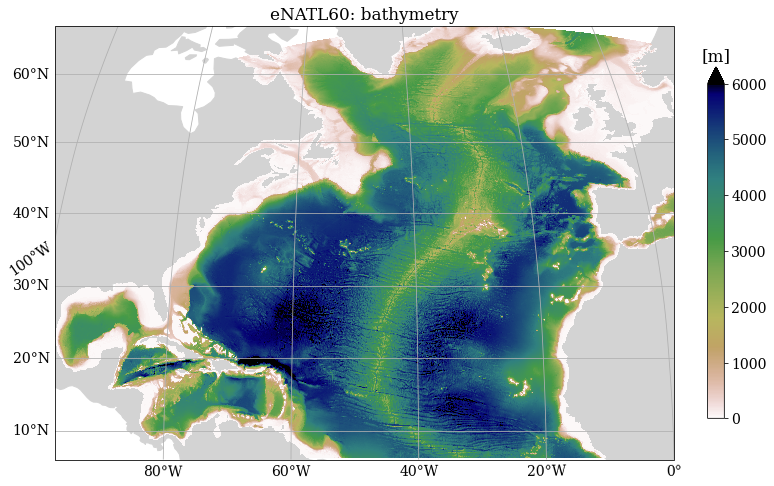

In [28]:
norm = mpl.colors.Normalize(vmin=0., vmax=6000)
cmap = "gist_earth_r"

fig, ax = prep_one_plot()
p = hbot.plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), 
                                     x="llon_cc", y="llat_cc", 
                                    norm=norm, cmap=cmap, cbar_kwargs={"fraction":.025, "label":""})
p.colorbar.ax.set_title(r"[m]")
plt.title("eNATL60: bathymetry")

In [29]:
fig.savefig("figures/eNATL60_bathy.png", dpi=300, bbox_inches="tight")